## Unsupervised Siamese Neuronal Network: Anchor - Positive - Positive Distorsion

Import libraries

In [3]:
import os
import random
import itertools
import numpy as np
import pandas as pd
import joblib
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn import metrics

import cv2

import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D, Activation, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from albumentations import *
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
from albumentations import OpticalDistortion
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, Normalize

import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import keras_tuner as kt

Data Loading

In [4]:
# Load the labeled faces in the wild dataset using scikit-learn's fetch_lfw_people function.
faces = fetch_lfw_people(min_faces_per_person=4, resize= 1, color=True, slice_=(slice(15, 235), slice(15, 235)))

# Get the number of unique classes in the dataset by counting the number of unique target names.
class_count = len(faces.target_names)
print(class_count)

610


Example of the images

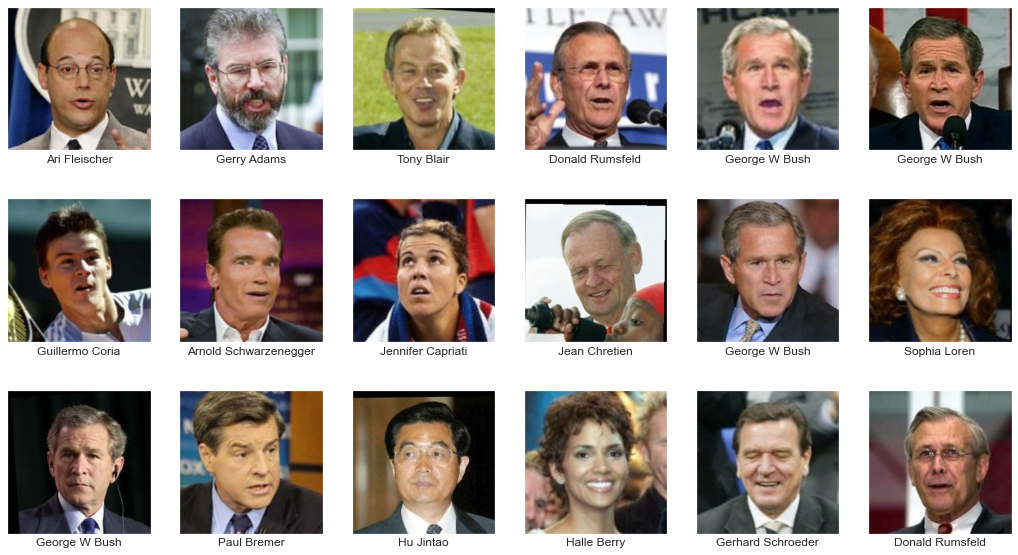

In [5]:
# Create a 3x6 grid of plots to display a sample of the images in the dataset.
sns.set()
fig, ax = plt.subplots(3, 6, figsize=(18, 10))

# For each plot in the grid, show an image from the dataset, scaled to values between 0 and 1 using division by 255.
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i] / 255)
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Image pre-processing

In [6]:
# Convert the images and labels to NumPy arrays.
face_images = np.array(faces.images)
face_labels = np.array(faces.target)

# Get the shape of the images in the dataset.
target_shape = face_images[0].shape

# Convert face_images into array
face_images = np.array(face_images, dtype="float32") 

Data Augmentation

In [ ]:
# Create an ImageDataGenerator object
datagen = ImageDataGenerator(
    featurewise_std_normalization=True, # Featurise Standar Normalization
    brightness_range= [0.5, 1.1], # Change brightness
    rotation_range=0.3, # Degrees (0 to 180) to randomly rotate images
    horizontal_flip=True, # Randomly flip images horizontally
    zoom_range=0.4, # Range for random zoom (0 to 1)
    fill_mode='nearest', # Strategy for filling in newly created pixels (e.g. when rotating)
    shear_range=5.0, # Shear range
    rescale=1. / 255, # Convert the pixel values of the images to floating point numbers between 0 and 1.
)

# Create an ImageDataGenerator object
datagen_rescale = ImageDataGenerator(
    rescale=1. / 255, # Convert the pixel values of the images to floating point numbers between 0 and 1.
    brightness_range= [0.5, 1.3], # Change brightness
)

# Create an ImageDataGenerator object
datagen_rescale_test = ImageDataGenerator(
    rescale=1. / 255, # Convert the pixel values of the images to floating point numbers between 0 and 1.
)

# Create an Abulmentations object
transform_negative = albumentations.Compose([
    GridDistortion(p=0.7,always_apply=True,distort_limit=0.7), # Grid Distortion
    OpticalDistortion(p=0.9,always_apply=True, distort_limit=0.7) , # Optical Distortion
    RandomBrightnessContrast(always_apply=True), # Change brightness
    
])

Generation of triplets

In [10]:
def generate_image_pairs(images, labels):
    
    """
    This function generates image pairs for training a Siamese Neural Network model.
    
    Parameters:
    images: array-like, shape (n_samples, height, width, channels)
            The images to use for generating the pairs.
    labels: array-like, shape (n_samples,)
            The labels corresponding to each image.
    
    Returns:
    pair_images: array-like, shape (n_pairs, 3, height, width, channels)
                 The generated pairs of images.
    pair_images_test: array-like, shape (n_pairs_test, 3, height, width, channels)
                      The generated pairs of images for testing purposes.
    """
    # Get unique labels in the dataset
    unique_labels = np.unique(labels)
    
    # Create a dictionary containing a list of indices for each unique label
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels) if
                                       label == curr_label])
    remove_index = []
    get_less_index = []
    
    # Get indices to remove if there are more than 30 images for a label
    # Get indices for labels with less than 5 images to include in testing data
    for value in label_wise_indices.values():
        if len(value) >= 45:
            remove_index.append(value[30:])
        if len(value) < 5:
            get_less_index.append(value[0:5])
  
    # Flatten the list of indices to remove and the list of indices to get for testing
    merged = list(itertools.chain(*remove_index))
    get_less = list(itertools.chain(*get_less_index))
    
    # Initialize empty lists for pairs for training data and testing data
    pair_images = []
    pair_images_test = []

    for index, image in enumerate(images):
        
        # Skip image if it needs to be removed
        if index not in merged + get_less:
            
            # Apply transformations
            aug_iter_2 = datagen.flow(image.reshape((1,220,220,3)),batch_size=1)
            aug_rescale_p = datagen_rescale.flow(image.reshape((1,220,220,3)),batch_size=1)
            aug_rescale_n = datagen_rescale_test.flow(image.reshape((1,220,220,3)),batch_size=1)

            for i in range(2):
                
                # Generate images
                image = next(aug_rescale_p)[0]
                image2 = next(aug_iter_2)[0]
                neg_image = next(aug_rescale_n)[0]
                
                # Create Pairs 
                pair_images.append((image, image2, neg_image))
                
        # Add images with less than 5 examples to testing data
        if index in get_less:
        
            # Randomly select an image with same label as current image
            pos_indices = label_wise_indices.get(labels[index]) 
            pos_image = images[np.random.choice(pos_indices)]
            
            # Randomly select an image with different label than current image
            neg_indices = np.where(labels != labels[index]) 
            neg_image = images[np.random.choice(neg_indices[0])] 
            
            # Apply transformations
            aug_iter_2 = datagen.flow(image.reshape((1,220,220,3)),batch_size=1)
            aug_rescale_p = datagen_rescale.flow(image.reshape((1,220,220,3)),batch_size=1)
            aug_rescale_n = datagen_rescale.flow(neg_image.reshape((1,220,220,3)),batch_size=1)
            
            # generate batch of images
            for i in range(1):

                # Generate images
                image = next(aug_rescale_p)[0]
                image2 = next(aug_iter_2)[0]
                neg_image = next(aug_rescale_n)[0]
                
                # Create Pairs 
                pair_images_test.append((image, image2, neg_image))           

    # Return numpy arrays for image pairs and training and testing data        
    return np.array(pair_images), np.array(pair_images_test)    


In [ ]:
# Generate image pairs from the input images and labels
images_dataset, images_dataset_test = generate_image_pairs(face_images, face_labels)

# Shuffle the generated image pairs and corresponding labels
images_dataset= shuffle(images_dataset) 

# Print the shape 
print(images_dataset.shape, images_dataset_test.shape)

In [14]:
# Distortion Abulmentations
for i in range(0,images_dataset.shape[0]):
    images_dataset[i, 2, :] = transform_negative(image=images_dataset[i, 2, :])['image']


Visualization of the positive and negative pairs

In [13]:
def visualize(image_pairs,  n = 5, title = "Image Pair Examples"):
    """ Visualize a few pairs """
    
    # Define a helper function to show an image in a subplot
    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    # Create a figure and subplots for displaying the image pairs
    fig = plt.figure(figsize=(30, 30)) 
    plt.title(title)
    axs = fig.subplots(n, 3)
    
    # Iterate over the first n image pairs
    for i in range(n):
        show(axs[i, 0], image_pairs[i][0])
        show(axs[i, 1], image_pairs[i][1])
        show(axs[i, 2], image_pairs[i][2])

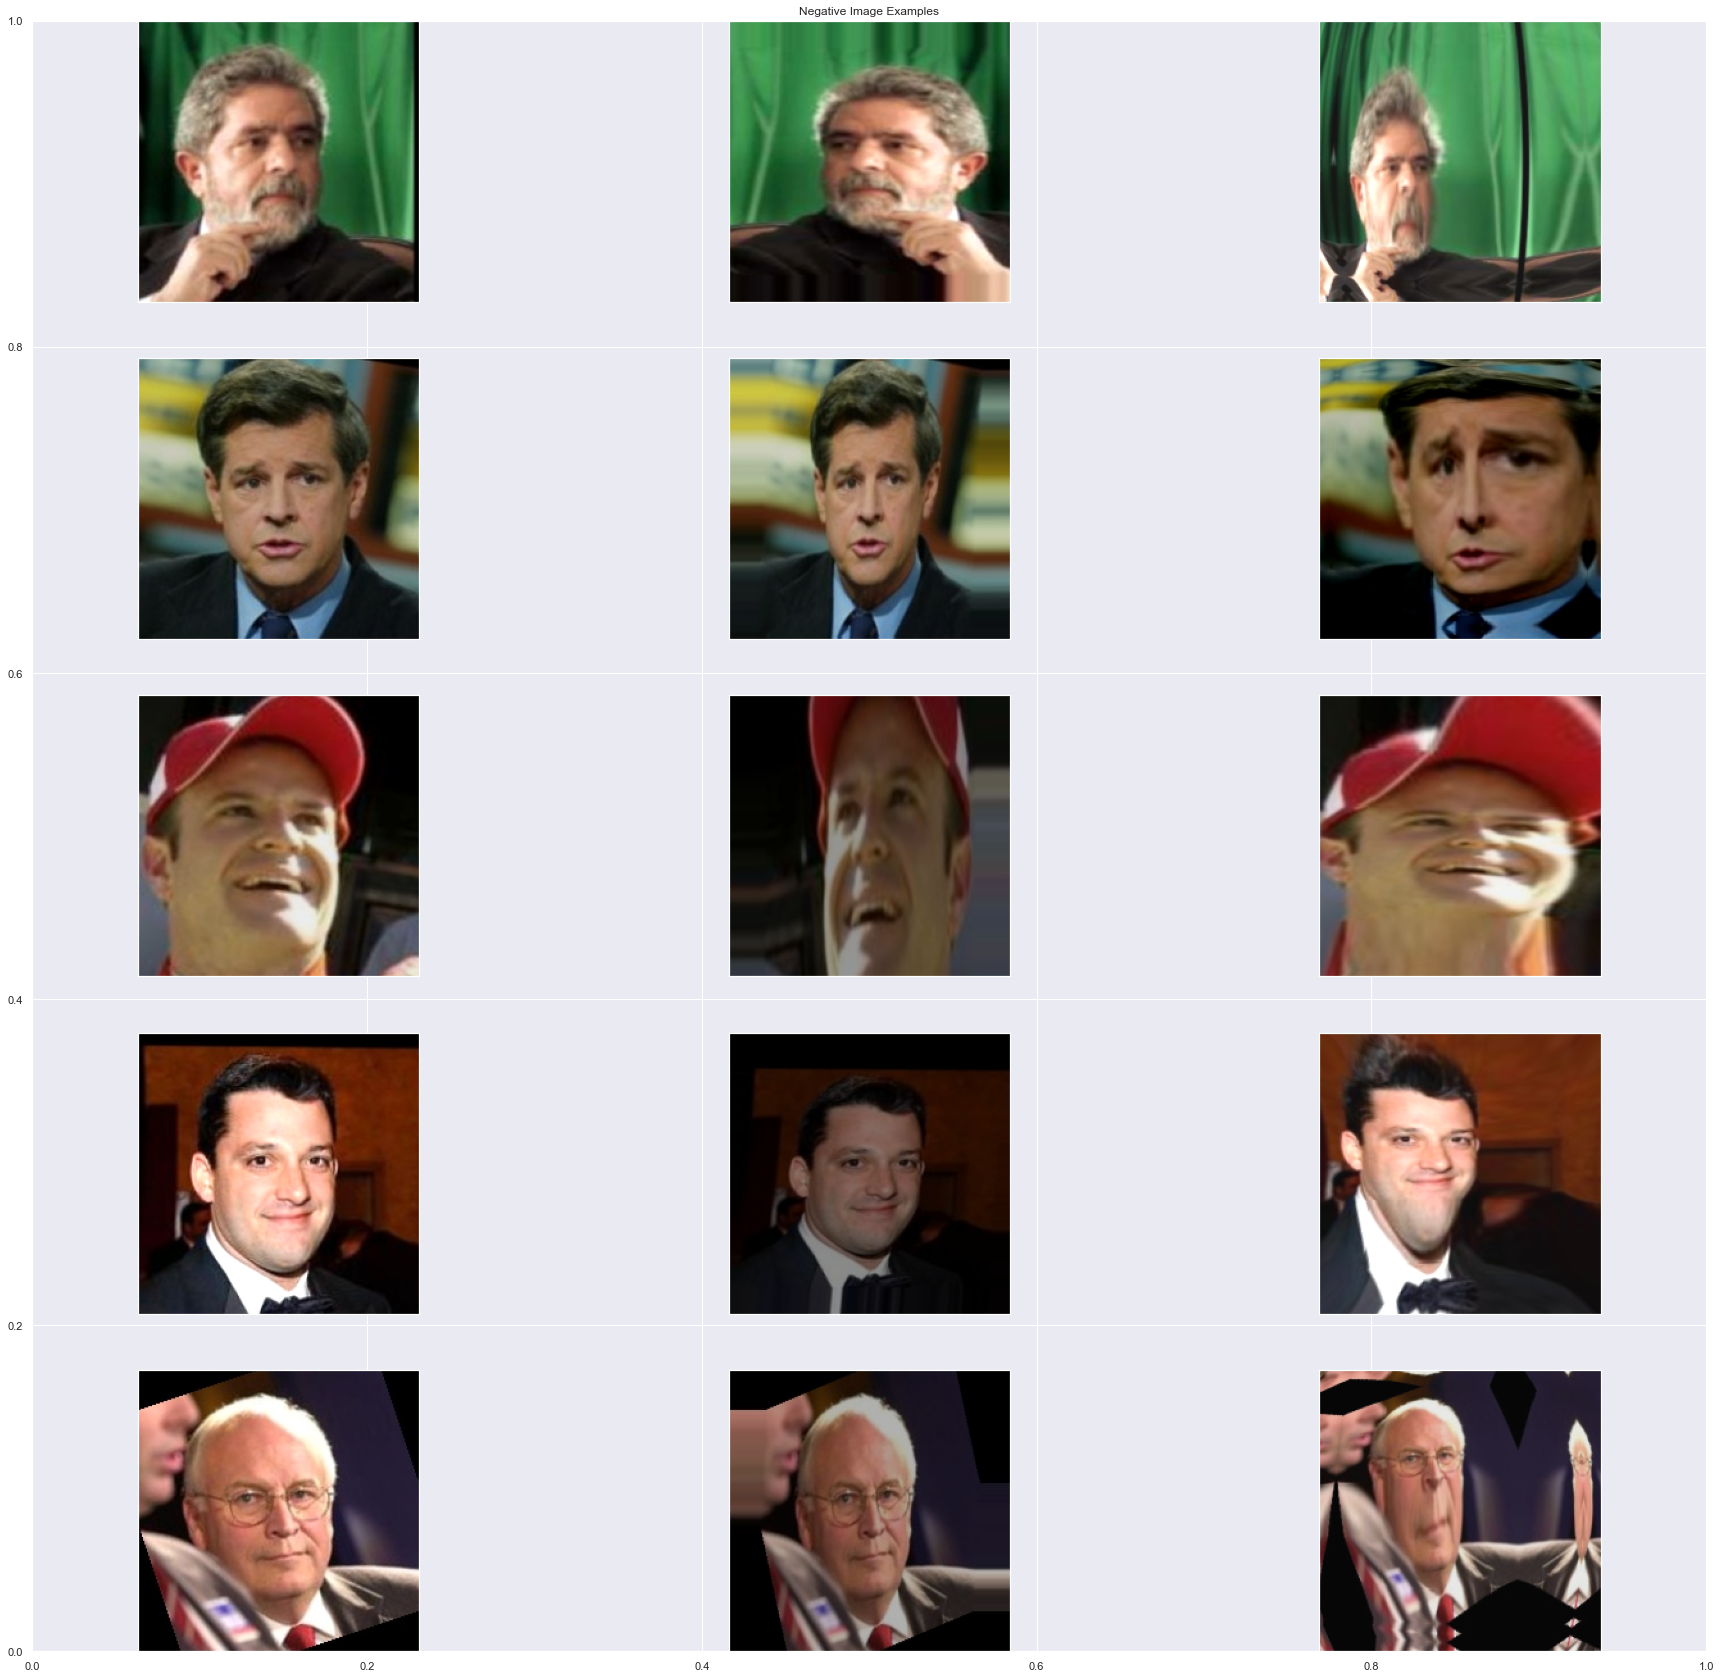

In [30]:
n = 5
# Get sample
visualize(images_dataset[0:n],
          title = "Negative Image Examples")

In [15]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


class SiameseModel(Model):
    
    """
    SiameseModel: class that implements a siamese neural network for image similarity learning.

    The class inherits from tf.keras.Model, and defines the following methods:

    init: Initializes the class instance.
    _build_embedding: Builds the embedding subnetwork.
    _build_siamese_network: Builds the siamese subnetwork.
    call: Overrides the call method of tf.keras.Model.
    train_step: Overrides the training step method of tf.keras.Model.
    test_step: Overrides the testing step method of tf.keras.Model.
    _compute_loss: Computes the loss of the siamese network.
    metrics: Returns a list of metrics to evaluate the model.
    The class also defines the following instance variables:

    target_shape: A tuple representing the input shape of the model.
    fineTune: A boolean indicating whether the model should be fine-tuned or not.
    margin: A float representing the margin parameter for the contrastive loss function.
    embedding: A tf.keras.Model instance representing the embedding subnetwork.
    siamese_network: A tf.keras.Model instance representing the siamese subnetwork.
    loss_tracker: A tf.keras.metrics.Mean instance representing the loss metric.
    """
    
    def __init__(self, target_shape, fineTune=True, margin=1):
        super().__init__()
        self.target_shape = target_shape
        self.fineTune = fineTune
        self.margin = margin
        self.embedding = self._build_embedding()
        self.siamese_network = self._build_siamese_network()
        self.loss_tracker = metrics.Mean(name="loss")

    
    # Create function to build embedding model
    def _build_embedding(self):
        
        # Define input layer
        inputs = tf.keras.layers.Input((220, 220, 3))

        # Load pre-trained VGG19 model
        base_model = tf.keras.applications.vgg19.VGG19(
            input_shape=(220, 220, 3), include_top=False, weights="imagenet"
        )

        if self.fineTune == True:
            base_model.trainable = True
        # Freeze all the layers if fineTune is False
        else:
            base_model.trainable = False
            
        # Connect input to base model and add dense layers
        x = base_model(inputs)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(512)(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        outputs = tf.keras.layers.Dense(128)(x)
        return tf.keras.Model(inputs, outputs)

    # Create function to build siamese network
    def _build_siamese_network(self):
      
        # Define input layers for anchor, positive, and negative images
        anchor_input = layers.Input(name="anchor", shape=(220, 220, 3))
        positive_input = layers.Input(name="positive", shape=(220, 220, 3))
        negative_input = layers.Input(name="negative", shape=(220, 220, 3))

        # Compute distances between anchor, positive, and negative embeddings using custom DistanceLayer
        distances = DistanceLayer()(
            self.embedding(anchor_input),
            self.embedding(positive_input),
            self.embedding(negative_input),
        )

        # Define and return siamese network
        return Model(
            inputs=[anchor_input, positive_input, negative_input], outputs=distances
        )
    
    # Define call function to call siamese network
    def call(self, inputs):
        return self.siamese_network(inputs)

    # Define train_step function to train model on a single batch of data
    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(
            loss, self.siamese_network.trainable_weights
        )

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    # Define test_step function to evaluate model on a single batch of data
    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
            
    # Define function to compute contrastive loss on a single batch of data
    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)

        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]
    


In [16]:
#Create a SiameseModel object with input shape of (220, 220, 3)
siamese_model = SiameseModel(target_shape=(220, 220, 3))

# Compile the model using RMSprop optimizer and 'loss' metric
siamese_model.compile(optimizer="RMSprop", metrics=['loss'])

# Train the model using the images_dataset and batch size of 6 for 8 epochs
triplet = siamese_model.fit([images_dataset[:, 0, :], images_dataset[:, 1, :], images_dataset[:, 2, :]], 
                              batch_size=6, epochs=8)


2023-03-30 20:16:39.744039: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/carmen/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-03-30 20:16:39.745185: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-30 20:16:39.745213: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (labs-ubuntu-20-04): /proc/driver/nvidia/version does not exist
2023-03-30 20:16:39.746431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Epoch 1/8
1583/1583 [==============================] - 918s 579ms/step - loss: 0.2927
Epoch 2/8
1583/1583 [==============================] - 916s 579ms/step - loss: 0.2161
Epoch 3/8
1583/1583 [==============================] - 997s 630ms/step - loss: 0.2154
Epoch 4/8
1583/1583 [==============================] - 1004s 634ms/step - loss: 0.1997
Epoch 5/8
1583/1583 [==============================] - 980s 619ms/step - loss: 0.2076
Epoch 6/8
1583/1583 [==============================] - 869s 549ms/step - loss: 0.2041
Epoch 7/8
1583/1583 [==============================] - 866s 547ms/step - loss: 0.2158
Epoch 8/8
1583/1583 [==============================] - 864s 546ms/step - loss: 0.2185


In [ ]:
siamese_model.siamese_network.save(r'../Final_model_abul_test_final_version-New-aug-margin1.pkl')

Function to monitorize the training

In [18]:
def plot_graphics(model):
    
    # Create a figure with 1 row and 2 columns, and set the figure size
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    
    # Plot the training and validation loss for each epoch in the first subplot
    ax.plot(np.arange(0,len(model.history["loss"]) ), model.history["loss"], label="loss")
    plt.legend()

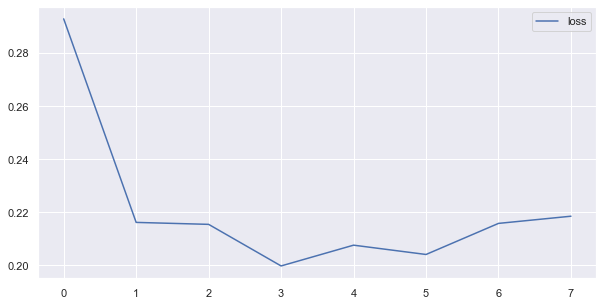

In [19]:
plot_graphics(triplet)

In [ ]:
loaded_model = tf.keras.models.load_model(r'Final_model_abul_test_final_version-New-aug-margin1.pkl')

Training Step

In [17]:
# Calculate Scores of the train data 
scores_trained = loaded_model.predict([images_dataset[:, 0, :], images_dataset[:, 1, :], images_dataset[:, 2, :]])

297/297 [==============================] - 898s 3s/step


In [21]:
# Create data frame with the scores and labels
df_distances_train = pd.DataFrame(scores_trained).T
df_distances_train.columns = ['positive', 'negative']

y = list(range(0,df_distances_train.shape[0])) + list(range(0, df_distances_train.shape[0]))
df_distances_train= pd.melt(df_distances_train, value_vars=['positive', 'negative'], var_name='category',
value_name='distance')

df_distances_train['y'] = y 

df_distances_train.loc[df_distances_train['category']=='positive', 'binary'] = 1
df_distances_train.loc[df_distances_train['category']=='negative', 'binary'] = 0
df_distances_train

In [23]:
# Calculate tpr, fpr, thresholds
fpr, tpr, thresholds = roc_curve(df_distances_train.binary, 
                                 df_distances_train.distance)

In [24]:
# Create data frame with the roc information
df_roc = pd.DataFrame({'FPR': fpr,
                           'TPR': tpr,
                           'Threshold': thresholds})

df_roc['FPR'] = (1 - df_roc['FPR'])*100
df_roc['TPR'] = (1 - df_roc['TPR'])*100

In [1]:
# Calculate AUC
1 - metrics.auc(fpr, tpr)

0.8408949819868285

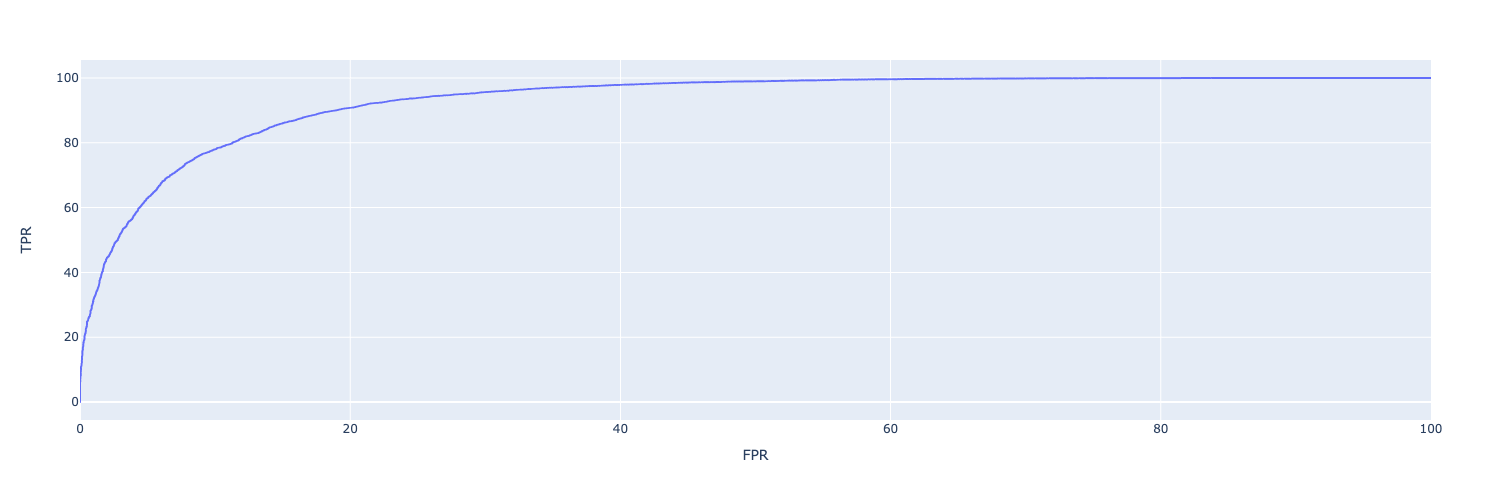

In [38]:
# Plot ROC curve
fig = px.line(df_roc, x='FPR', y='TPR', custom_data={'FPR', 'Threshold', 'TPR'},
                      height=500,  width=500) 

fig.update_traces(mode="lines", 
                   hovertemplate = "Threshold %{customdata[1]:.2f}  <br> TPR %{customdata[0]:.2f}% <br> FPR %{customdata[2]:.2f}%")



Test Score

In [44]:
# Calculate scores for test dataset
distances_trained_test = loaded_model.predict([images_dataset_test[:, 0, :], images_dataset_test[:, 1, :], images_dataset_test[:, 2, :]])

24/24 [==============================] - 70s 3s/step


In [45]:
# Creation of a data set with the scores
df_distances_test = pd.DataFrame(distances_trained_test).T
df_distances_test.columns = ['positive', 'negative']

In [46]:
# Distribution of the positive images
df_distances_test['positive'].describe()

count    748.000000
mean      23.803482
std       16.195805
min        0.482953
25%       12.518523
50%       19.937576
75%       31.140702
max      136.798904
Name: positive, dtype: float64

In [47]:
# Distribution of the negative images
df_distances_test['negative'].describe()

count    748.000000
mean      68.064789
std       39.919609
min       11.478786
25%       40.431314
50%       57.519665
75%       84.380421
max      383.830078
Name: negative, dtype: float64

In [43]:
# Add true labels
y = list(range(0,df_distances_test.shape[0])) + list(range(0, df_distances_test.shape[0]))
df_distances_test= pd.melt(df_distances_test, value_vars=['positive', 'negative'], var_name='category',
value_name='distance')

df_distances_test['y'] = y 

df_distances_test.loc[df_distances_test['category']=='positive', 'true_binary'] = 1
df_distances_test.loc[df_distances_test['category']=='negative', 'true_binary'] = 0
df_distances_test

distances_array = (df_distances_test[['distance', 'y', 'true_binary']]).to_numpy()

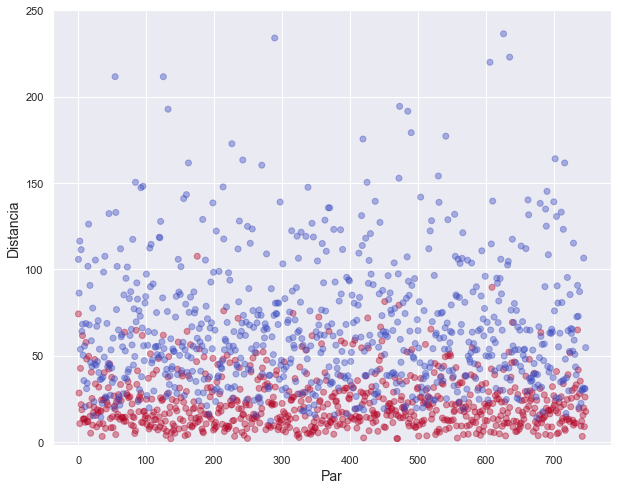

In [38]:
# Plot distances distribution
plt.figure(figsize=(10,8))
plt.scatter(distances_array[:,1], distances_array[:,0], c=distances_array[:,2], cmap='coolwarm', alpha= 0.4)
plt.xlabel('Par',fontsize=14)
plt.ylabel('Distancia',fontsize=14)
plt.ylim([-2, 250])
plt.show()

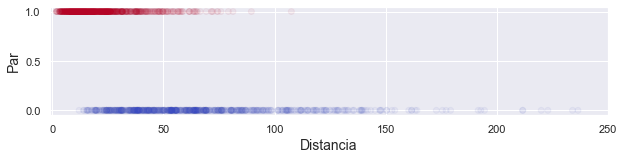

In [40]:
# Plot distances distribution
plt.figure(figsize=(10,2))
plt.scatter(distances_array[:,0], distances_array[:,2], c=distances_array[:,2], cmap='coolwarm', alpha=0.05)
plt.xlabel('Distancia',fontsize=14)
plt.ylabel('Par',fontsize=14)
plt.xlim([-1, 250])
plt.show()

In [50]:
# Creation data set for validation 
df_distances_test = pd.DataFrame(distances_trained_test).T
df_distances_test.columns = ['positive', 'negative']

y = list(range(0,df_distances_test.shape[0])) + list(range(0, df_distances_test.shape[0]))
df_distances_test= pd.melt(df_distances_test, value_vars=['positive', 'negative'], var_name='category',
value_name='distance')

df_distances_test['y'] = y 

df_distances_test.loc[df_distances_test['category']=='positive', 'true_binary'] = 1
df_distances_test.loc[df_distances_test['category']=='negative', 'true_binary'] = 0

In [57]:
# Calculate labels threshold 10
df_distances_test[['true_binary','distance']]
df_distances_test.loc[df_distances_test['distance'] > 10, 'distance_10'] = 0
df_distances_test.loc[df_distances_test['distance'] <= 10, 'distance_10'] = 1

In [58]:
# Clasification report
print(classification_report(df_distances_test['true_binary'], df_distances_test['distance_10']))

              precision    recall  f1-score   support

         0.0       0.55      1.00      0.71       748
         1.0       1.00      0.17      0.30       748

    accuracy                           0.59      1496
   macro avg       0.77      0.59      0.50      1496
weighted avg       0.77      0.59      0.50      1496



In [59]:
# Metrics
tn, fp, fn, tp = confusion_matrix(df_distances_test['true_binary'], df_distances_test['distance_10'], labels=[0, 1]).ravel()
print(tn, fp, fn, tp)  # 1 1 1 1

748 0 618 130


In [60]:
# FPR
fpr = fp / (fp + tn)
print(fpr)

0.0


In [61]:
# Calculate labels threshold 24
df_distances_test.loc[df_distances_test['distance'] > 24, 'distance_24'] = 0
df_distances_test.loc[df_distances_test['distance'] <= 24, 'distance_24'] = 1

In [62]:
# Clasification report
print(classification_report(df_distances_test['true_binary'], df_distances_test['distance_24']))

              precision    recall  f1-score   support

         0.0       0.70      0.94      0.80       748
         1.0       0.91      0.60      0.72       748

    accuracy                           0.77      1496
   macro avg       0.80      0.77      0.76      1496
weighted avg       0.80      0.77      0.76      1496



In [63]:
# Metrics
tn, fp, fn, tp = confusion_matrix(df_distances_test['true_binary'], df_distances_test['distance_24'], labels=[0, 1]).ravel()
print(tn, fp, fn, tp)  # 1 1 1 1

702 46 298 450


In [64]:
# FPR
fpr = fp / (fp + tn)
print(fpr)

0.06149732620320856


In [57]:
# Calculate labels threshold 38
df_distances_test.loc[df_distances_test['distance'] > 38, 'distance_38'] = 0
df_distances_test.loc[df_distances_test['distance'] <= 38, 'distance_38'] = 1

In [58]:
# Clasification report
print(classification_report(df_distances_test['true_binary'], df_distances_test['distance_38']))

              precision    recall  f1-score   support

         0.0       0.84      0.77      0.80       748
         1.0       0.79      0.85      0.82       748

    accuracy                           0.81      1496
   macro avg       0.81      0.81      0.81      1496
weighted avg       0.81      0.81      0.81      1496



In [59]:
# Metrics
tn, fp, fn, tp = confusion_matrix(df_distances_test['true_binary'], df_distances_test['distance_38'], labels=[0, 1]).ravel()
print(tn, fp, fn, tp)  # 1 1 1 1

579 169 113 635


In [60]:
# FPR
fpr = fp / (fp + tn)
print(fpr)

0.22593582887700533


In [65]:
# Calculate labels threshold 49
df_distances_test.loc[df_distances_test['distance'] > 49, 'distance_49'] = 0
df_distances_test.loc[df_distances_test['distance'] <= 49, 'distance_49'] = 1

In [66]:
# Clasification report
print(classification_report(df_distances_test['true_binary'], df_distances_test['distance_49']))

              precision    recall  f1-score   support

         0.0       0.90      0.61      0.72       748
         1.0       0.70      0.93      0.80       748

    accuracy                           0.77      1496
   macro avg       0.80      0.77      0.76      1496
weighted avg       0.80      0.77      0.76      1496



In [67]:
# Metrics
tn, fp, fn, tp = confusion_matrix(df_distances_test['true_binary'], df_distances_test['distance_49'], labels=[0, 1]).ravel()
print(tn, fp, fn, tp)  # 1 1 1 1

454 294 53 695


In [68]:
# FPR
fpr = fp / (fp + tn)
print(fpr)

0.393048128342246


In [76]:
# Calculate labels threshold 16
df_distances_test.loc[df_distances_test['distance'] > 16, 'distance_16'] = 0
df_distances_test.loc[df_distances_test['distance'] <= 16, 'distance_16'] = 1

In [77]:
# Clasification report
print(classification_report(df_distances_test['true_binary'], df_distances_test['distance_16']))

              precision    recall  f1-score   support

         0.0       0.62      0.99      0.76       748
         1.0       0.97      0.38      0.55       748

    accuracy                           0.69      1496
   macro avg       0.79      0.69      0.65      1496
weighted avg       0.79      0.69      0.65      1496



In [78]:
# Metrics
tn, fp, fn, tp = confusion_matrix(df_distances_test['true_binary'], df_distances_test['distance_16'], labels=[0, 1]).ravel()
print(tn, fp, fn, tp)  # 1 1 1 1

740 8 462 286


In [79]:
# FPR
fpr = fp / (fp + tn)
print(fpr)

0.0106951871657754


Example image

In [20]:
def generate_image_pairs_final_image(images, labels):
    
    """
    This function generates image pairs for training a Siamese Neural Network model.
    
    Parameters:
    images: array-like, shape (n_samples, height, width, channels)
            The images to use for generating the pairs.
    labels: array-like, shape (n_samples,)
            The labels corresponding to each image.
    
    Returns:
    pair_images: array-like, shape (n_pairs, 3, height, width, channels)
                 The generated pairs of images.
    pair_images_test: array-like, shape (n_pairs_test, 3, height, width, channels)
                      The generated pairs of images for testing purposes.
    """
    
    # Get unique labels in the dataset
    unique_labels = np.unique(labels)
    label_wise_indices = dict()
    
    # Create a dictionary containing a list of indices for each unique label
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels) if
                                       label == curr_label])

    remove_index = []
    get_less_index = []
    
    # Get indices to remove if there are more than 30 images for a label
    # Get indices for labels with less than 5 images to include in testing data
    for value in label_wise_indices.values():
        if len(value) >= 45:
            remove_index.append(value[30:])
        if len(value) < 5:
            get_less_index.append(value[0:5])
  
    # Flatten the list of indices to remove and the list of indices to get for testing
    merged = list(itertools.chain(*remove_index))
    get_less = list(itertools.chain(*get_less_index))

    pair_images = []
    pair_images_test = []

    for index, image in enumerate(images):
        
       # Add images with less than 5 examples to testing data
        if index in get_less:
            
            # Randomly select an image with same label as current image
            pos_indices = label_wise_indices.get(labels[index]) 
            pos_image = images[np.random.choice(pos_indices)] 

            # Randomly select an image with different label than current image
            neg_indices = np.where(labels != labels[index])
            neg_image = images[267] 
            
            # Apply transformations
            aug_iter_2 = datagen.flow(pos_image.reshape((1,220,220,3)),batch_size=1)
            aug_rescale_p = datagen_rescale.flow(image.reshape((1,220,220,3)),batch_size=1)
            aug_rescale_n = datagen_rescale.flow(neg_image.reshape((1,220,220,3)),batch_size=1)
           
            # Generate batch of images
            for i in range(1):
    
                # Generate images
                image_1 = next(aug_iter_2)[0]
                image = next(aug_rescale_p)[0]
                neg_image = next(aug_rescale_n)[0]
       
                # Create Pairs 
                pair_images_test.append((image, image_1, neg_image))
                   
    # Return numpy arrays for image pairs and training and testing data       
    return np.array(pair_images), np.array(pair_images_test)    


In [21]:
# Generate image pairs from the input images and labels
images_dataset_pr, image_dataset_test_pr = generate_image_pairs_final_image(face_images, face_labels)

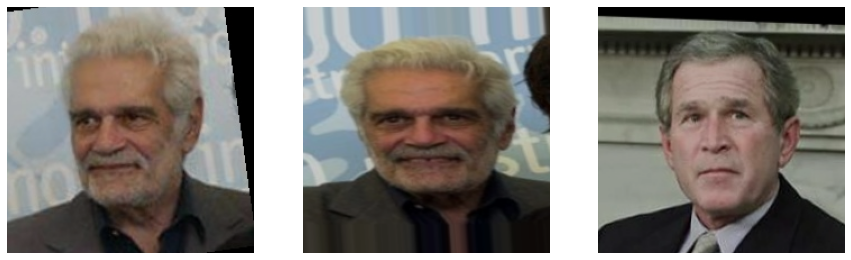

In [22]:
# Plot the original and three augmented samples side by side
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# Generate a batch of 3 images by iterating the augmented data generator 3 times
for i in range(3):

    # Get the next augmented image from the iterator
    image = image_dataset_test_pr[1][i]
 
    # Plot the augmented image
    ax[i].imshow(image)
    ax[i].axis('off')

In [23]:
# Calculate scores for test dataset
distances_trained_test = loaded_model.predict([image_dataset_test_pr[:, 0, :], image_dataset_test_pr[:, 1, :], image_dataset_test_pr[:, 2, :]])

24/24 [==============================] - 69s 3s/step


In [26]:
# Create data frame with the scores and labels
df_distances_t= pd.DataFrame(distances_trained_test).T
df_distances_t.columns = ['positive', 'negative']

In [27]:
df_distances_t.iloc[1]

positive    17.957695
negative    60.948120
Name: 1, dtype: float32